# Ejercicios MongoDB y PyMongo.

### 1.- Conectar con MongoDB.

In [21]:
from pymongo import MongoClient
from pprint import pprint
import re
import datetime
import json
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns
import operator

plt.rcParams["figure.figsize"] = (16,9)

In [2]:
client = MongoClient()
db = client.Restaurants
collection = db.restaurants

### 3.- Visualizacion de los Datos.

Generamos gráficos con matplotlib que muestren la distribución de valores de "borough" y "cuisine". Los posibles valores de cada variable y su número de registros asociados deben generarse mediante una consulta en pymongo.

Empezaremos por Borough:

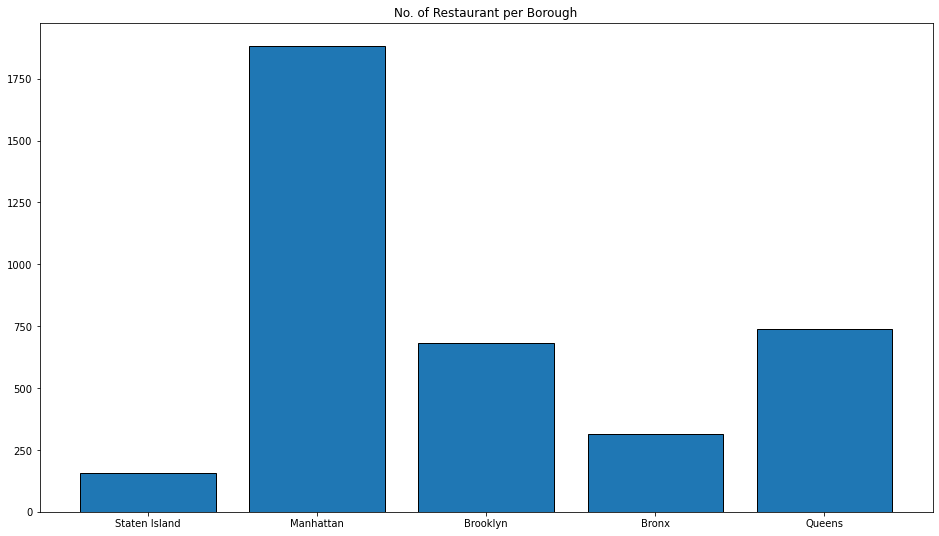

In [13]:
cursor_borough = db.restaurants.aggregate([
  {
    '$group' : { '_id' : "$borough", 'result' : {'$sum': 1} } 
  }
])

borough = []
count = []

for doc in cursor_borough :
  borough.append(doc['_id'])
  count.append(doc['result'])

ax = plt.subplot()

ax.bar(borough,count, edgecolor='black')
ax.set_title("No. of Restaurant per Borough")

plt.show()


Y ahora Cuisine:

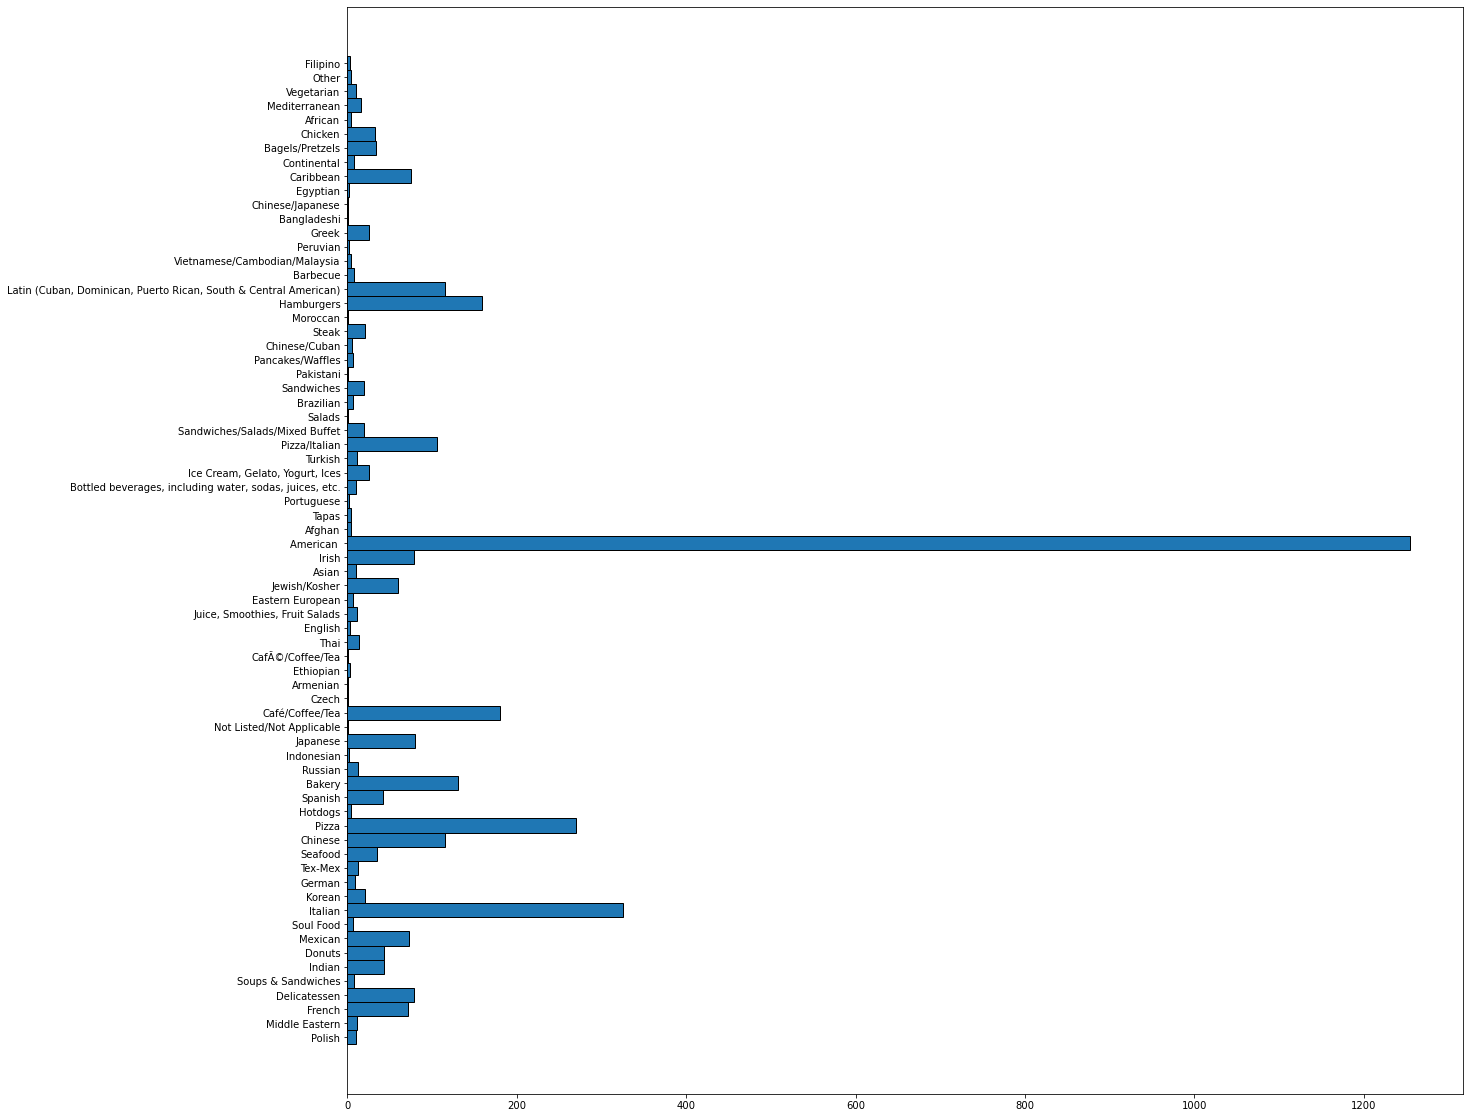

In [56]:
cursor_cuisine = db.restaurants.aggregate([
  {
    '$group' : { '_id' : "$cuisine", 'result' : {'$sum': 1} } 
  }
])

cuisine = []
count = []

for doc in cursor_cuisine :
  cuisine.append(doc['_id'])
  count.append(doc['result'])

plt.figure(figsize=(20,20))
ax = plt.subplot()
ax.barh(cuisine, count, height=1, edgecolor='black')
ax.tick_params(axis='y',labeltop=True)


plt.show()

### 4.- Insertar el JSON "new_restaurants".

In [53]:
with open('new_restaurants.json') as file :
    new_collection = json.load(file)

In [54]:
collection.insert_many(new_collection)

### 5.- Añadir "avg_score".

In [95]:
cursor_score = db.restaurants.aggregate([
    {'$project' : {'grades' : 1} }
])

for doc in cursor_score :
    if len(doc['grades']) != 0 :    
        total_score = 0
        for elem in doc['grades'] :
            total_score += elem['score']
        avr_score = total_score/len(doc['grades'])

        db.restaurants.update_one(
            {'_id': doc['_id']},
            { '$set' : {'avr_score' : avr_score} }
        )
    else :
        db.restaurants.update_one(
            {'_id': doc['_id']},
            { '$set' : {'avr_score' : 0} }
        )
  

### 6.- Visualizacion geografica.

Primero obtenemos las coordenadas y el tipo de cocina en un data frame.

In [97]:
cursor_datos = db.restaurants.aggregate([
    {'$project' : {'_id' : 0, 'address.coord' : 1, 'cuisine' : 1} }
])

long = []
lat = []
cuisine = []
for doc in cursor_datos :
    long.append(doc['address']['coord'][0])
    lat.append(doc['address']['coord'][1])
    cuisine.append(doc['cuisine'])

data = {'long' : long, 'lat' : lat, 'cuisine' : cuisine}
dataframe = pd.DataFrame.from_dict(data)

In [98]:
dataframe

,long,lat,cuisine
0,-73.856077,40.848447,Bakery
1,-73.961704,40.662942,Hamburgers
2,-73.985136,40.767692,Irish
3,-73.982420,40.579505,American
4,-73.860115,40.731174,Jewish/Kosher
...,...,...,...
3771,-74.025217,40.622463,Chinese
3772,-73.856077,40.848447,Bakery
3773,-73.856077,40.848447,Bakery
3774,-73.856077,40.848447,Bakery


Creamos ahora el marco del mapa.

In [99]:
BBox = ( dataframe.long.min(), dataframe.long.max(),  dataframe.lat.min(), dataframe.lat.max() )
BBox

(-119.6368672, 153.1628795, -28.0168595, 51.6514664)

Claramente hay datos demasiado extremos que nos nos ayudan, vamos a tomar las coordenadas del cuadro resultante de tomar una foto de Manhattan entera segun la pagina proporcionada por el vlog.

In [116]:
BBox = ( -74.0273, -73.7794, 40.8870, 40.6978 )

Cargamos el mapa.

In [117]:
ny_map = plt.imread('map.png')

Elegimos los colores para cada tipo de cocina.

In [130]:
dataframe.cuisine.unique()

array(['Bakery', 'Hamburgers', 'Irish', 'American ', 'Jewish/Kosher',
       'Delicatessen', 'Ice Cream, Gelato, Yogurt, Ices', 'Chinese',
       'Chicken', 'Turkish', 'Caribbean', 'Donuts',
       'Sandwiches/Salads/Mixed Buffet', 'Bagels/Pretzels', 'Continental',
       'Pizza', 'Italian', 'Steak', 'Polish',
       'Latin (Cuban, Dominican, Puerto Rican, South & Central American)',
       'German', 'French', 'Pizza/Italian', 'Mexican', 'Spanish',
       'Café/Coffee/Tea', 'Tex-Mex', 'Pancakes/Waffles', 'Soul Food',
       'Seafood', 'Hotdogs', 'Greek', 'Not Listed/Not Applicable',
       'African', 'Japanese', 'Indian', 'Armenian', 'Thai',
       'Chinese/Cuban', 'Mediterranean', 'Korean',
       'Bottled beverages, including water, sodas, juices, etc.',
       'Russian', 'Eastern European', 'Middle Eastern', 'Asian',
       'Ethiopian', 'Vegetarian', 'Barbecue', 'Egyptian', 'English',
       'Other', 'Sandwiches', 'Portuguese', 'Indonesian',
       'Chinese/Japanese', 'Filipino', 'J

Como hay muchos tipos distintos, vamos a colorear solo los mas destacables por categorias. El criterio principal es continentes.

In [171]:
colores = { 
    'American ' : 'red',
    'Hamburgers' : 'red',
    'Hotdogs' : 'red',
    'Barbecue' : 'red', 
    'Steak' : 'red',
    'Chicken' : 'red', 

    'Sandwiches' : 'green',
    'Soups & Sandwiches' : 'green',
    'Sandwiches/Salads/Mixed Buffet' : 'green',
    'Salads' : 'green',
    'Vegetarian' : 'green',
    'Delicatessen' : 'green',

    'Italian' : 'blue',
    'Pizza' : 'blue',
    'Irish' : 'blue',
    'Polish' : 'blue',
    'Spanish' : 'blue',
    'German' : 'blue', 
    'French' : 'blue', 
    'Pizza/Italian' : 'blue',
    'Greek' : 'blue',
    'Mediterranean' : 'blue', 
    'Russian' : 'blue', 
    'Eastern European' : 'blue',
    'Portuguese' : 'blue',
    'English' : 'blue',
    'Tapas' : 'blue',
    'Czech' : 'blue',
    'Continental' : 'blue',

    'Café/Coffee/Tea' : 'orange',
    'CafÃ©/Coffee/Tea' : 'orange',
    'Bagels/Pretzels' : 'orange',
    'Donuts' : 'orange',
    'Bakery' : 'orange',
    'Ice Cream, Gelato, Yogurt, Ices' : 'orange',
    'Pancakes/Waffles' : 'orange',

    'Moroccan' : 'brown',
    'Armenian' : 'brown',
    'Jewish/Kosher' : 'brown',
    'Turkish' : 'brown', 
    'Middle Eastern' : 'brown', 
    'Afghan' : 'brown',
    'Pakistani' : 'brown',

    'Chinese/Japanese' : 'yellow',
    'Chinese' : 'yellow',
    'Japanese' : 'yellow',
    'Indian' : 'yellow', 
    'Thai' : 'yellow',
    'Korean' : 'yellow',
    'Indonesian' : 'yellow',
    'Filipino' : 'yellow',
    'Asian' : 'yellow',
    'Vietnamese/Cambodian/Malaysia' : 'yellow',
    'Bangladeshi' : 'yellow',
    'Chinese/Cuban' : 'yellow',

    'Caribbean' : 'lime', 
    'Latin (Cuban, Dominican, Puerto Rican, South & Central American)' : 'lime',
    'Mexican' : 'lime', 
    'Tex-Mex' : 'lime', 
    'Brazilian' : 'lime',
    'Peruvian' : 'lime', 

    'Seafood' : 'cyan',

    'Not Listed/Not Applicable' : 'black',
    'Other' : 'black',

    'Bottled beverages, including water, sodas, juices, etc.' : 'magenta',
    'Juice, Smoothies, Fruit Salads' : 'magenta',

    'African' : 'saddlebrown', 
    'Ethiopian' : 'saddlebrown',
    'Egyptian' : 'saddlebrown',  
    'Soul Food' : 'saddlebrown',   
}

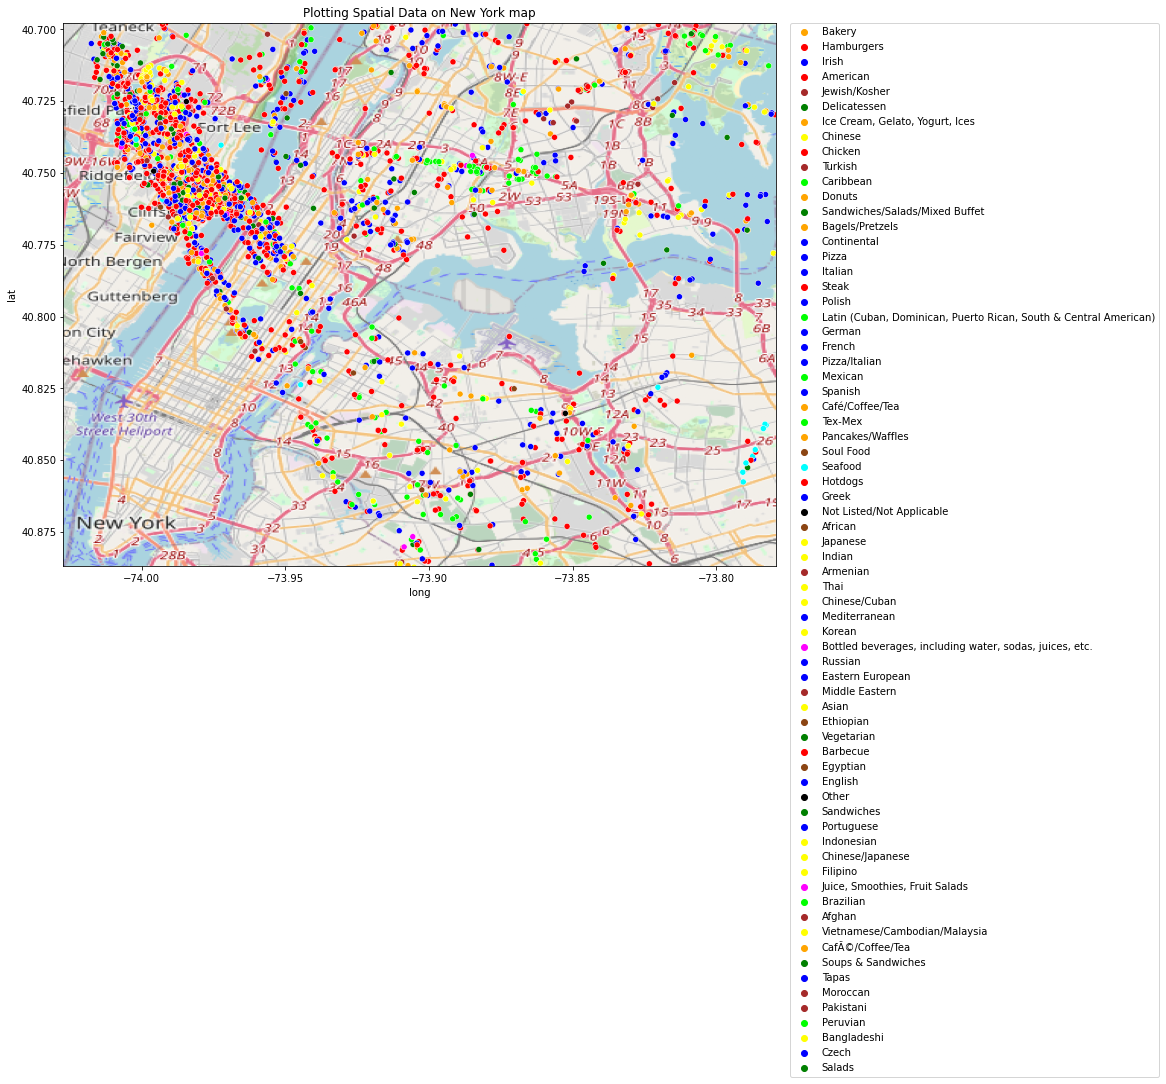

In [180]:
fig, ax = plt.subplots(figsize = (25,10))
sns.scatterplot(x="long", y="lat", hue="cuisine",data=dataframe, palette=colores)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax.set_title('Plotting Spatial Data on New York map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ny_map, zorder=0, extent = BBox, aspect= 'equal')